In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# 分析01

> 実データ `01_Data/` に対して適用する 


- skip_showdoc: true
- skip_exec: true

In [ ]:
#| hide
from typing import NamedTuple
from KalmanPaper import gen00, simple as sp
import jax.random as jrd
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen00, EKF, VA, simple
from matplotlib import pyplot as plt
from typing import Tuple, Callable
from functools import partial
import h5py
import plotly.express as px
import plotly.io as pio
import pandas as pd
pio.renderers.default = 'notebook'
from dash import Dash, html, dcc, callback, Output, Input

## dow_jones_index

https://archive.ics.uci.edu/dataset/312/dow+jones+index

This dataset contains weekly data for the Dow Jones Industrial Index. It has been used in computational investing research.

| 項目名                                      | 説明                        |
| :--------------------------------------- | :------------------------ |
| **quarter**                              | 年間の四半期（1 = 1〜3月、2 = 4〜6月） |
| **stock**                                | 株式のシンボル（ティッカーコード）         |
| **date**                                 | 週の最終営業日（通常は金曜日）           |
| **open**                                 | 週の始めの株価（始値）               |
| **high**                                 | 週の最高株価                    |
| **low**                                  | 週の最安株価                    |
| **close**                                | 週の終わりの株価（終値）              |
| **volume**                               | その週に取引された株式の出来高（取引株数）     |
| **percent_change_price**                 | 週を通しての株価変動率（％）            |
| **percent_change_volume_over_last_week** | 前週と比較した出来高の変化率（％）         |
| **previous_weeks_volume**                | 前週の出来高（取引株数）              |
| **next_weeks_open**                      | 翌週の始値                     |
| **next_weeks_close**                     | 翌週の終値                     |
| **percent_change_next_weeks_price**      | 翌週の株価変動率（％）               |
| **days_to_next_dividend**                | 次回配当までの日数                 |
| **percent_return_next_dividend**         | 次回配当による利回り（％）             |



In [ ]:
df = pd.read_csv("01_Data/dow_jones_index/dow_jones_index.data")
df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.355713,86758820.0,$83.28,$81.18,-2.521610,75,0.568801
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.221032,68230855.0,$80.93,$79.78,-1.420980,68,0.578960
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.508519,78616295.0,$80.00,$79.02,-1.225000,61,0.589120
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.22500,8.811952,92380844.0,$78.65,$76.78,-2.377620,54,0.594786


In [ ]:
df1 = df.set_index("date")
df1

,quarter,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,,
1/7/2011,1,AA,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1/14/2011,1,AA,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
1/21/2011,1,AA,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
1/28/2011,1,AA,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
2/4/2011,1,AA,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/27/2011,2,XOM,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.355713,86758820.0,$83.28,$81.18,-2.521610,75,0.568801
6/3/2011,2,XOM,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.221032,68230855.0,$80.93,$79.78,-1.420980,68,0.578960
6/10/2011,2,XOM,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.508519,78616295.0,$80.00,$79.02,-1.225000,61,0.589120


<Axes: xlabel='date'>

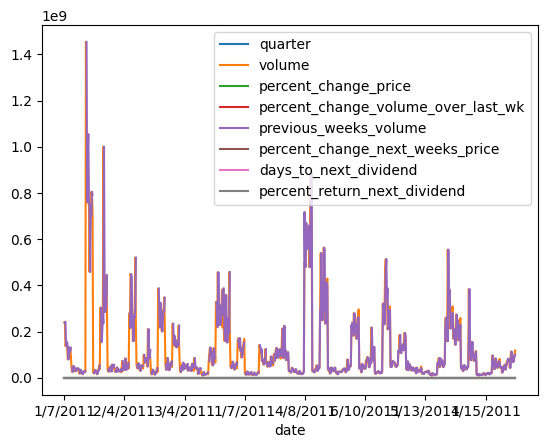

In [ ]:
df1.plot()

- x quarter

In [ ]:
dol_cols = [
  "open", 
  "high", 
  "low", 
  "close", 
  "next_weeks_open", 
  "next_weeks_close"
  ]

df1[dol_cols] = (
    df1[dol_cols]
    .replace('[\$,]', '', regex=True)  # $, , を削除
    .astype(float)                     # float型に変換
)

In [ ]:
df1

,quarter,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,,,
1/7/2011,1,AA,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
1/14/2011,1,AA,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
1/21/2011,1,AA,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
1/28/2011,1,AA,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
2/4/2011,1,AA,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5/27/2011,2,XOM,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
6/3/2011,2,XOM,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
6/10/2011,2,XOM,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120


In [ ]:
df1.groupby("stock").count()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
stock,,,,,,,,,,,,,,
AA,25,25,25,25,25,25,25,24,24,25,25,25,25,25
AXP,25,25,25,25,25,25,25,24,24,25,25,25,25,25
BA,25,25,25,25,25,25,25,24,24,25,25,25,25,25
BAC,25,25,25,25,25,25,25,24,24,25,25,25,25,25
CAT,25,25,25,25,25,25,25,24,24,25,25,25,25,25
CSCO,25,25,25,25,25,25,25,24,24,25,25,25,25,25
CVX,25,25,25,25,25,25,25,24,24,25,25,25,25,25
DD,25,25,25,25,25,25,25,24,24,25,25,25,25,25
DIS,25,25,25,25,25,25,25,24,24,25,25,25,25,25


In [ ]:
numcols = ["open", "high", "low", "close", "volume", "percent_change_price", "percent_change_volume_over_last_wk", "previous_weeks_volume", "next_weeks_open", "next_weeks_close", "percent_change_next_weeks_price", "days_to_next_dividend", "percent_return_next_dividend"]
dfAA = df1[df1["stock"] == "AA"][numcols]
dfAA

,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
date,,,,,,,,,,,,,
1/7/2011,15.82,16.72,15.78,16.42,239655616,3.792670,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.428490,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.470660,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
1/28/2011,15.87,16.63,15.82,16.13,151379173,1.638310,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
2/4/2011,16.18,17.39,16.18,17.14,154387761,5.933250,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
2/11/2011,17.33,17.48,16.97,17.37,114691279,0.230814,-25.712195,154387761.0,17.39,17.28,-0.632547,90,0.172712
2/18/2011,17.39,17.68,17.28,17.28,80023895,-0.632547,-30.226696,114691279.0,16.98,16.68,-1.766780,83,0.173611
2/25/2011,16.98,17.15,15.96,16.68,132981863,-1.766780,66.177694,80023895.0,16.81,16.58,-1.368230,76,0.179856
3/4/2011,16.81,16.94,16.13,16.58,109493077,-1.368230,-17.663150,132981863.0,16.58,16.03,-3.317250,69,0.180941


In [ ]:
cols1 = ["open", "high", "low", "close", "next_weeks_open", "next_weeks_close"]
cols2 = ["volume", "previous_weeks_volume"]
cols3 = ["percent_change_price", "percent_change_next_weeks_price"]
cols4 = ["percent_change_volume_over_last_wk"]
cols5 = ["days_to_next_dividend"]
cols6 = ["percent_return_next_dividend"]

<Axes: xlabel='date'>

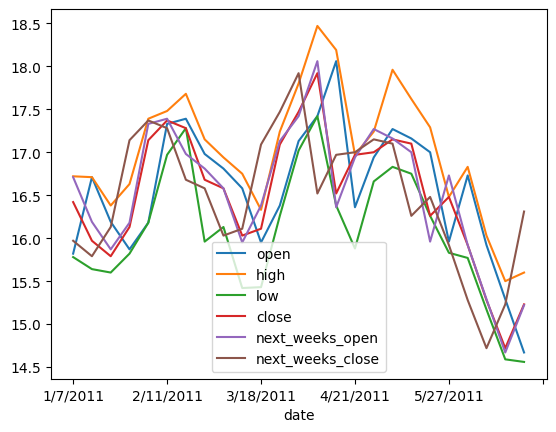

In [ ]:
dfAA[cols1].plot()

<Axes: xlabel='date'>

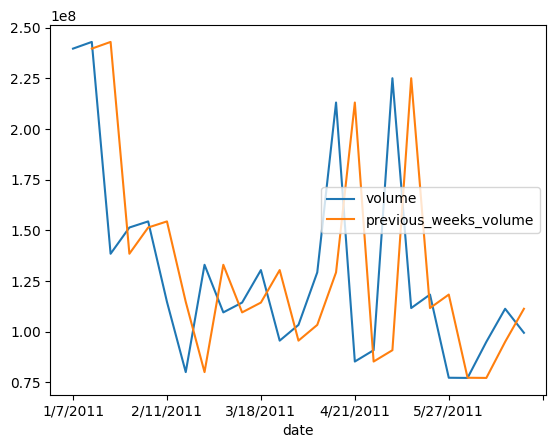

In [ ]:
dfAA[cols2].plot()

<Axes: xlabel='date'>

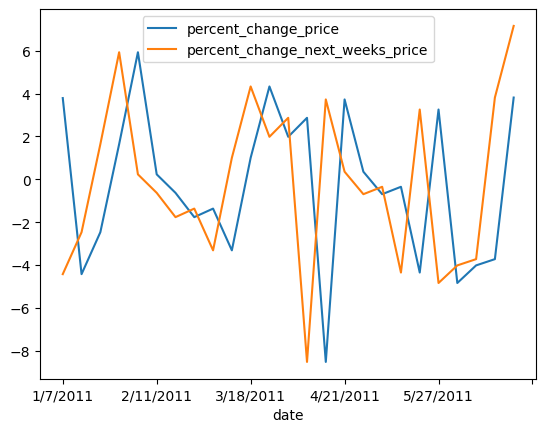

In [ ]:
dfAA[cols3].plot()

<Axes: xlabel='date'>

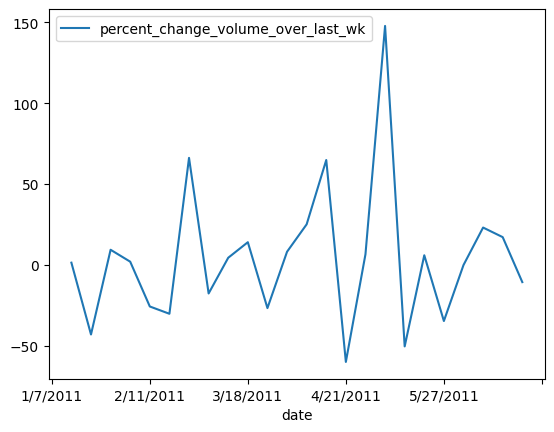

In [ ]:
dfAA[cols4].plot()

<Axes: xlabel='date'>

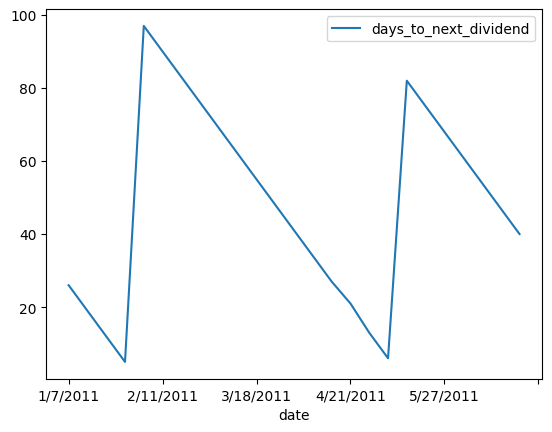

In [ ]:
dfAA[cols5].plot()

<Axes: xlabel='date'>

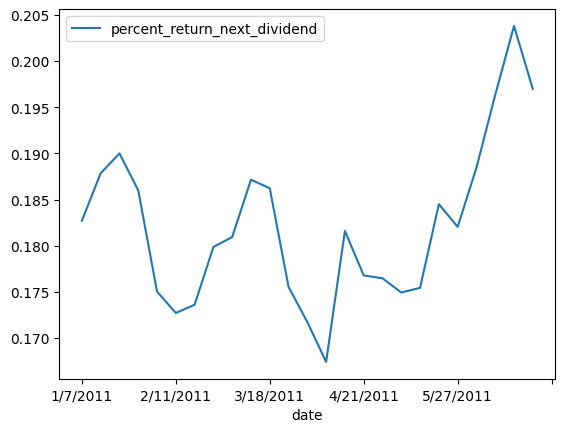

In [ ]:
dfAA[cols6].plot()

### True: 上がる、False: 下がる

In [ ]:
dfAA["open_updown"] = dfAA["open"] < dfAA["next_weeks_open"]
dfAA["close_updown"] = dfAA["close"] < dfAA["next_weeks_close"]

<matplotlib.collections.PathCollection>

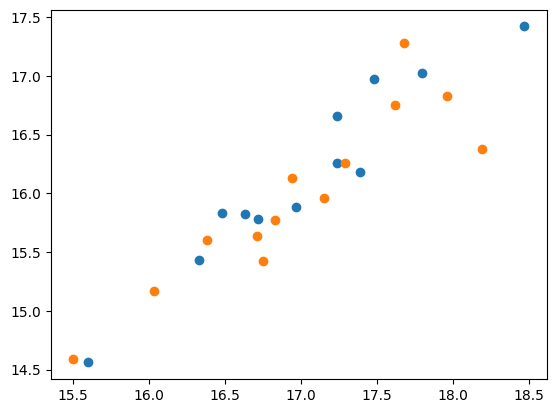

In [ ]:
up = dfAA[dfAA["open_updown"]]
down = dfAA[~dfAA["open_updown"]]
plt.scatter(x = up["high"], y = up["low"])
plt.scatter(x = down["high"], y = down["low"])

<matplotlib.collections.PathCollection>

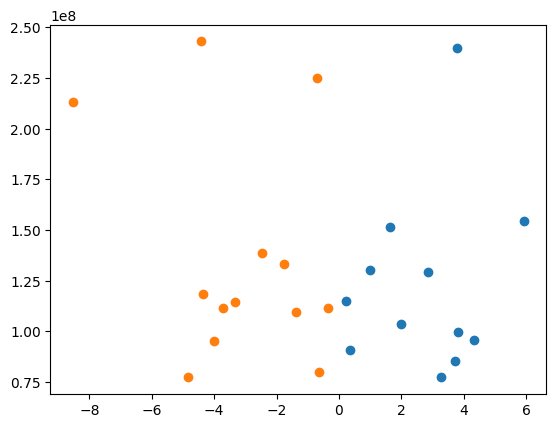

In [ ]:
plt.scatter(x = up[cols3[0]], y = up[cols2[0]])
plt.scatter(x = down[cols3[0]], y = down[cols2[0]])

<matplotlib.collections.PathCollection>

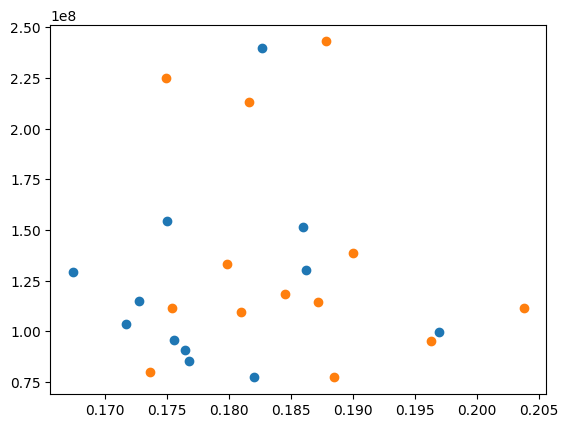

In [ ]:
plt.scatter(x = up[cols6[0]], y = up[cols2[0]])
plt.scatter(x = down[cols6[0]], y = down[cols2[0]])

<matplotlib.collections.PathCollection>

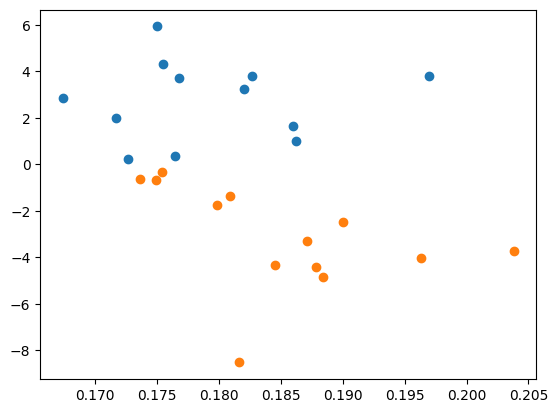

In [ ]:
plt.scatter(x = up[cols6[0]], y = up[cols3[0]])
plt.scatter(x = down[cols6[0]], y = down[cols3[0]])

<matplotlib.collections.PathCollection>

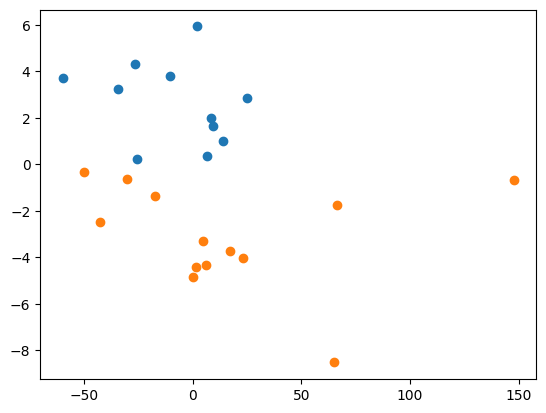

In [ ]:
plt.scatter(x = up[cols4[0]], y = up[cols3[0]])
plt.scatter(x = down[cols4[0]], y = down[cols3[0]])